In [1]:
from IPython.display import clear_output as c
!pip install kaggle
!pip install kagglehub
!pip install tqdm
!pip install torch torchvision matplotlib scikit-learn
c()

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pavelbiz/eyes-rtte")

print("Path to dataset files:", path)

100%|██████████| 40.4M/40.4M [00:00<00:00, 96.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pavelbiz/eyes-rtte/versions/1


In [3]:
import shutil
import os

source_folder = '/root/.cache/kagglehub/datasets/'
destination_folder = '/content/'

# Iterate through all files and subdirectories in the source folder
for item in os.listdir(source_folder):
    source_path = os.path.join(source_folder, item)
    destination_path = os.path.join(destination_folder, item)

    # Copy files and directories recursively
    if os.path.isfile(source_path):
        shutil.copy2(source_path, destination_path)
    elif os.path.isdir(source_path):
        shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print("Files copied successfully!")

Files copied successfully!


In [4]:
import os

# Define the paths to the folders
female_eyes_folder = '/content/pavelbiz/eyes-rtte/versions/1/femaleeyes'
male_eyes_folder = '/content/pavelbiz/eyes-rtte/versions/1/maleeyes'

# Count the number of images in each folder
num_female_eyes = len([f for f in os.listdir(female_eyes_folder) if os.path.isfile(os.path.join(female_eyes_folder, f))])
num_male_eyes = len([f for f in os.listdir(male_eyes_folder) if os.path.isfile(os.path.join(male_eyes_folder, f))])

# Print the results
print("Number of images in 'femaleeyes' folder:", num_female_eyes)
print("Number of images in 'maleeyes' folder:", num_male_eyes)

Number of images in 'femaleeyes' folder: 5202
Number of images in 'maleeyes' folder: 6323


In [5]:
import os
import shutil
import random
from tqdm import tqdm

# Paths
input_root = '/content/pavelbiz/eyes-rtte/versions/1'  # Update if needed
female_dir = os.path.join(input_root, 'femaleeyes')
male_dir = os.path.join(input_root, 'maleeyes')

output_root = './processed_eye_dataset'
splits = ['train', 'val', 'test']
genders = {'female': 'F', 'male': 'M'}

# Split ratios
split_ratio = {
    'train': 0.8,
    'val': 0.15,
    'test': 0.5
}

# Create output folders
for split in splits:
    for gender in genders.keys():
        os.makedirs(os.path.join(output_root, split, gender), exist_ok=True)

# Function to process each gender folder
def process_folder(src_folder, gender_label, prefix):
    images = os.listdir(src_folder)
    images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    total = len(images)
    train_end = int(split_ratio['train'] * total)
    val_end = train_end + int(split_ratio['val'] * total)

    split_ranges = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    counter = 0
    for split, split_imgs in split_ranges.items():
        for img in tqdm(split_imgs, desc=f"Processing {split} - {gender_label}"):
            src_path = os.path.join(src_folder, img)
            new_name = f"{prefix}_{counter:05d}.jpg"
            dst_path = os.path.join(output_root, split, gender_label, new_name)
            shutil.copy(src_path, dst_path)
            counter += 1

# Process both folders
process_folder(female_dir, 'female', 'F')
process_folder(male_dir, 'male', 'M')

print("\n ✅ Dataset split and organized successfully!")


Processing test - male: 100%|██████████| 317/317 [00:00<00:00, 7642.58it/s]


 ✅ Dataset split and organized successfully!


In [6]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Image size and batch size
IMG_SIZE = 128
BATCH_SIZE = 32

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Loaders
data_root = 'processed_eye_dataset'

train_data = datasets.ImageFolder(os.path.join(data_root, 'train'), transform=transform_train)
val_data   = datasets.ImageFolder(os.path.join(data_root, 'val'), transform=transform_val_test)
test_data  = datasets.ImageFolder(os.path.join(data_root, 'test'), transform=transform_val_test)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


In [8]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)


In [9]:
from tqdm import tqdm

best_val_acc = 0
patience = 5
trigger_times = 0

for epoch in range(25):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    val_acc = evaluate(model, val_loader)
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Epoch 1: 100%|██████████| 289/289 [00:27<00:00, 10.57it/s, loss=2.94]


Validation Accuracy: 0.9606


Epoch 2: 100%|██████████| 289/289 [00:27<00:00, 10.65it/s, loss=3.07]


Validation Accuracy: 0.9618


Epoch 3: 100%|██████████| 289/289 [00:26<00:00, 10.80it/s, loss=0.165]


Validation Accuracy: 0.9688


Epoch 4: 100%|██████████| 289/289 [00:34<00:00,  8.44it/s, loss=0.00388]


Validation Accuracy: 0.9601


Epoch 5: 100%|██████████| 289/289 [00:26<00:00, 11.10it/s, loss=0.000534]


Validation Accuracy: 0.9699


Epoch 6: 100%|██████████| 289/289 [00:27<00:00, 10.35it/s, loss=0.00959]


Validation Accuracy: 0.9624


Epoch 7: 100%|██████████| 289/289 [00:26<00:00, 10.92it/s, loss=0.000727]


Validation Accuracy: 0.9641


Epoch 8: 100%|██████████| 289/289 [00:26<00:00, 10.91it/s, loss=0.0137]


Validation Accuracy: 0.9688


Epoch 9: 100%|██████████| 289/289 [00:26<00:00, 10.70it/s, loss=0.000145]


Validation Accuracy: 0.9705


Epoch 10: 100%|██████████| 289/289 [00:26<00:00, 10.91it/s, loss=2.52e-5]


Validation Accuracy: 0.9647


Epoch 11: 100%|██████████| 289/289 [00:29<00:00,  9.68it/s, loss=4.55]


Validation Accuracy: 0.9699


Epoch 12: 100%|██████████| 289/289 [00:26<00:00, 10.92it/s, loss=0.000738]


Validation Accuracy: 0.9676


Epoch 13: 100%|██████████| 289/289 [00:26<00:00, 10.93it/s, loss=0.000575]


Validation Accuracy: 0.9664


Epoch 14: 100%|██████████| 289/289 [00:26<00:00, 10.90it/s, loss=6.4e-5]


Validation Accuracy: 0.9740


Epoch 15: 100%|██████████| 289/289 [00:26<00:00, 11.00it/s, loss=1.03e-5]


Validation Accuracy: 0.9722


Epoch 16: 100%|██████████| 289/289 [00:26<00:00, 10.79it/s, loss=0.000279]


Validation Accuracy: 0.9711


Epoch 17: 100%|██████████| 289/289 [00:26<00:00, 11.00it/s, loss=3.7]


Validation Accuracy: 0.9688


Epoch 18: 100%|██████████| 289/289 [00:26<00:00, 11.03it/s, loss=4.62e-5]


Validation Accuracy: 0.9780


Epoch 19: 100%|██████████| 289/289 [00:26<00:00, 10.88it/s, loss=5.98]


Validation Accuracy: 0.9734


Epoch 20: 100%|██████████| 289/289 [00:26<00:00, 11.02it/s, loss=0.000127]


Validation Accuracy: 0.9774


Epoch 21: 100%|██████████| 289/289 [00:26<00:00, 10.99it/s, loss=0.0213]


Validation Accuracy: 0.9797


Epoch 22: 100%|██████████| 289/289 [00:26<00:00, 11.01it/s, loss=0.0213]


Validation Accuracy: 0.9670


Epoch 23: 100%|██████████| 289/289 [00:26<00:00, 11.03it/s, loss=2.14]


Validation Accuracy: 0.9682


Epoch 24: 100%|██████████| 289/289 [00:26<00:00, 11.00it/s, loss=0.000294]


Validation Accuracy: 0.9653


Epoch 25: 100%|██████████| 289/289 [00:26<00:00, 11.05it/s, loss=6.64e-6]


Validation Accuracy: 0.9705


In [10]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

test_acc = evaluate(model, test_loader)
print(f"✅ Test Accuracy: {test_acc:.4f}")


✅ Test Accuracy: 0.9654


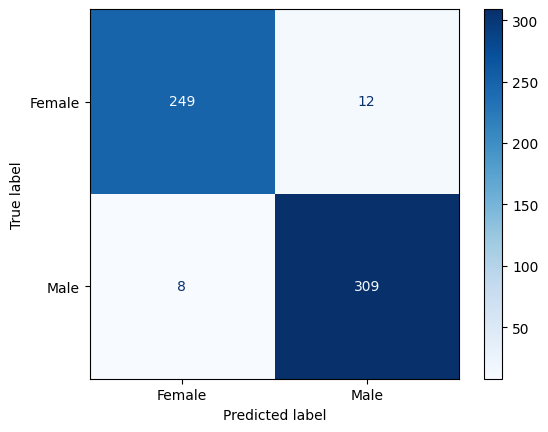

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def show_confusion_matrix():
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
    disp.plot(cmap="Blues")
    plt.show()

show_confusion_matrix()


In [12]:
torch.save(model.state_dict(), "best_model.pth")
